In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

In [4]:
df = pd.read_csv('../data/training_results.csv')

In [13]:
df[(df.n_way==10 )& (df.dataset=='flickr8k')] 

,Name,n_way,k_shot,n_class_additions,n_classes_start,algorithm,dataset,validation_query_accuracy_epoch,train_query_accuracy_step,train_quick_update_inner_accuracy_epoch,validation_quick_update_inner_accuracy_epoch
8,polished-spaceship-50,10,5,1,2,OML,flickr8k,0.750123,0.76,NaN,NaN
11,decent-voice-52,10,5,5,2,FSCL,flickr8k,0.867778,0.90,0.968652,0.973765
14,ruby-pine-51,10,5,1,2,FSCL,flickr8k,0.768272,0.72,0.883229,0.889198
18,chocolate-brook-48,10,5,5,2,OML,flickr8k,0.728210,0.78,NaN,NaN


/var/folders/20/tzn3lm1s1h9f4tshjwtkn9bc0000gn/T/ipykernel_3173/1867552060.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('k_shot_accuracy.png', transparent=True, pad_inches=.2, frameon=False)


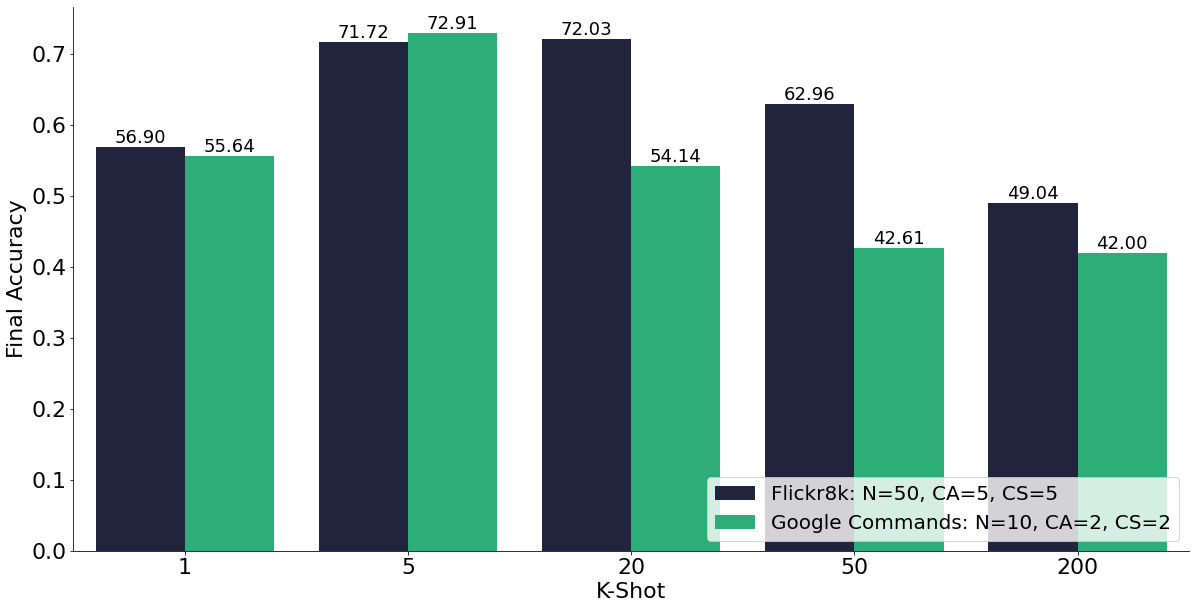

In [151]:
plot_df_1 = df[(df.n_way==50)&(df.n_class_additions==5)&(df.n_classes_start==5)&(df.algorithm=='FSCL')&(df.dataset=='flickr8k')].\
    drop(columns=['Name']).groupby(['k_shot']).max().reset_index(drop=False)
plot_df_2 = df[(df.n_way==10)&(df.n_class_additions==1)&(df.n_classes_start==2)&(df.algorithm=='FSCL')&(df.dataset=='google_commands')].\
    drop(columns=['Name']).groupby(['k_shot']).max().reset_index(drop=False)
plot_df = pd.concat([plot_df_1, plot_df_2])

def rename_(name):
    if name == 'flickr8k':
        return 'Flickr8k: N=50, CA=5, CS=5'
    else:
        return "Google Commands: N=10, CA=2, CS=2"

plot_df['dataset']=plot_df['dataset'].apply(rename_)
plot_df.rename(columns={'k_shot':'K-Shot', 'validation_query_accuracy_epoch':'Final Accuracy', 'dataset':'Dataset'}, inplace=True)

plt.figure(figsize=(20, 10))
# set colours allowed to use to certain hex value
sns.set_palette(sns.color_palette(["#1D2140", "#17C37B"])) 
sns.barplot(x='K-Shot', y='Final Accuracy', hue='Dataset', data=plot_df)
#add the value on top of the bar
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '{:1.2f}'.format(p.get_height()*100), fontsize=18, color='black', ha='center', va='bottom')

# make the legend text bigger
plt.legend(loc='lower right', prop={'size': 20})
# make plot font size bigger
plt.rcParams.update({'font.size': 22})

# remove top grid line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('k_shot_accuracy.png', transparent=True, pad_inches=.2, frameon=False)
plt.show()

# Generate CL insights

In [1]:
from src.models import WordClassificationAudio2DCnn, WordClassificationAudioCnnPool as WordClassificationAudioCnn, WordClassificationRnn
from src.losses import ClassificationLoss
from src.algorithms import FSCL, OML
from src.data.datasets import Flickr8kWordClassification, GoogleCommandsWordClassification
from src.data.samplers import SpokenWordTaskBatchSampler
from src.utils import flatten_dict

import torch.nn as nn
import torch

/Users/ruanvdmerwe/miniforge3/envs/fscl/lib/python3.9/site-packages/learn2learn/vision/benchmarks/omniglot_benchmark.py:7: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from PIL.Image import LANCZOS


In [ ]:
optim = {
'name': 'adam',
'inner_steps': 5,
'val_inner_steps': 5,
'gradient_clip_val': 0,
'inner_learning_rate': 0.001,
'outer_learning_rate': 0.0001,
'scheduler': False,
'scheduler_step': 30,
'scheduler_decay': 0.1,
}

encoder = WordClassificationAudio2DCnn(
    256, 
    64, 
    input_channels=39
)

class FSCLModel(nn.Module):
    def __init__(self, encoder, embedding_dim, n_classes):
        super().__init__()

        self.encoder = encoder

        def return_classification_layer(embedding_dim):
            layer = nn.Linear(embedding_dim, 1)
            torch.nn.init.xavier_uniform(layer.weight, )
            layer = nn.Sequential(
                nn.ReLU(),
                layer
            )
            return layer

        layers = [return_classification_layer(embedding_dim) for _ in range(n_classes)]
        self.classifiers = nn.ModuleList(layers)

    def forward(self, audio, total_classes_present):
        features = self.encoder(audio)
        layer_logits = []
        for c_layer in range(total_classes_present):
            layer_logits.append(self.classifiers[c_layer](features))
        logits = torch.cat(layer_logits, dim=1)
        return {'logits':logits}


loss_fn = ClassificationLoss()

model = FSCLModel(encoder, 256, 50)
algorithm = FSCL.load_from_checkpoint(
    './nway50_k5.ckpt', 
    model=model, 
    training_steps=5,
    intial_training_steps=30,
    n_classes_start=5,
    n_class_additions=5,
    loss_func=loss_fn,
    optim_config=optim,
    k_shot=5,
    quick_adapt=True
)
model = algorithm.model

In [ ]:
df = pd.read_csv('C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv')


In [ ]:
import yaml

with open('../config/conversion_method/mfcc.yaml') as f:
    conv_config = yaml.safe_load(f) 

valiadation_dataset = Flickr8kWordClassification(
    meta_path='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv',
    audio_root='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/wavs/', 
    conversion_config=conv_config,
    stemming=True, 
    lemmetise=False          
)


def pad_audio(x, max_audio_len=101, pad_both_sides=False):
    import torch.nn.functional as F
    if x.size(-1) > max_audio_len:
        x = x[:,:max_audio_len]
    else:
        if pad_both_sides:
            pad_lenght = int(max_audio_len-x.size(-1))//2
            x = F.pad(x, (pad_lenght, pad_lenght+1 if int(max_audio_len-x.size(-1))%2!=0 else pad_lenght), 'constant', 0)
        else:
            x = F.pad(x, (0, int(max_audio_len-x.size(-1))), 'constant', 0)
    return x

df = pd.read_csv('C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv')
words_keep = [
'surf', 'wave', 'crowd', 'fight', 'togeth', 'ski',
'bridg', 'wood', 'teenag', 'lot', 'mud', 'pool', 'tabl', 'out',
'wet', 'footbal', 'make', 'team', 'shop', 'their', 'edg', 'guitar',
'across', 'area', 'do', 'trick', 'bike', 'obstacl', 'tri', 'rider',
'track', 'room', 'him', 'jacket', 'glass', 'open', 'them', 'cap',
'color', 'set', 'pant', 'wrestl', 'basketbal', 'climber', 'face',
'mountain', 'tent', 'shore', 'ground', 'bar'
]
df = df[df.stem.isin(words_keep)]

# sample 5 instances of each stem
df = df.groupby('stem').apply(lambda x: x.sample(5)).reset_index(drop=True)
df.to_csv('./plot_data_words.csv', index=False)


valiadation_dataset = Flickr8kWordClassification(
    meta_path='plot_data_words.csv',
    audio_root='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/wavs/', 
    conversion_config=conv_config,
    stemming=True, 
    lemmetise=False          
)

In [1]:
N_CLASSES = [5,10]
K_SHOT = [5,10,20,50]
UPDATES = [True, False]

LR = 0.0001
N_TRAINING_STEPS = 30

In [ ]:
for N in N_CLASSES:
    for K in K_SHOT:
        for UPDATE in UPDATES:

            file_name = f'./results/words/nway{N}_k{K}_update{UPDATE}_MAMLCON.csv'

            STEPS = K*N


            groups = []
            test_groups = []

            for i in range(0, len(valiadation_dataset), STEPS):
                arrays = []
                labels = []

                for j in range(0+i, STEPS+i):
                    arrays.append(pad_audio(torch.tensor(valiadation_dataset[j][0])).unsqueeze(0))
                    labels.append(torch.tensor(valiadation_dataset[j][1]))
                
                arrays = torch.concat(arrays,dim=0)

                # take every 5th instance as test
                test_arrays = arrays[::5]
                test_labels = labels[::5]

                # skip every 5th instance
                arrays = torch.concat([array.unsqueeze(0) for i, array in enumerate(arrays) if i%5!=0 or i==0],dim=0)
                labels = [label for i, label in enumerate(labels) if i%5!=0 or i==0]

                groups.append({'data':arrays, 'labels':labels})
                test_groups.append({'data':test_arrays, 'labels':test_labels})

            results = pd.DataFrame()

            model = FSCLModel(encoder, 256, 50)
            algorithm = FSCL.load_from_checkpoint(
                './nway50_k5.ckpt', 
                model=model, 
                training_steps=5,
                intial_training_steps=30,
                n_classes_start=5,
                n_class_additions=5,
                loss_func=loss_fn,
                optim_config=optim,
                k_shot=5,
                quick_adapt=True
            )
            model = algorithm.model

            criterion = ClassificationLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=LR)

            # Training loop
            for n, group in enumerate(groups):
                model.train()
                data, labels = group['data'], group['labels']
                for i in range(N_TRAINING_STEPS):
                    # Clear gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    outputs = model(data, (n+1)*N)
                    outputs['labels'] = torch.tensor(labels)
                    # Compute loss
                    loss = criterion(outputs)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                        
                # Print loss for each epoch
                print(f'Training loss: {loss.item():.4f}')

                if UPDATE:

                    for group in groups[:n+1]:
                        data, labels = group['data'], group['labels']
                        optimizer.zero_grad()

                        # take every 5th instance
                        data = data[::5]
                        labels = labels[::5]

                        # Forward pass
                        outputs = model(data, (n+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        # Compute loss
                        loss = criterion(outputs)
                        
                        # Backward pass and optimization
                        loss.backward()
                        optimizer.step()

                with torch.no_grad():
                    model.eval()

                    for i, group in enumerate(test_groups[:n+1]):
                        data, labels = group['data'], group['labels']
                        outputs = model(data, (i+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        loss = criterion(outputs)

                        predicted_labels = torch.argmax(outputs['logits'], dim=1)
                        accuracy = torch.sum(predicted_labels == torch.tensor(labels)).item() / len(labels)

                        results = pd.concat([results,pd.DataFrame({'loss':[loss.item()], 'accuracy':[accuracy], 'group':[i], 'training_group':[n]})])
                        results.to_csv(file_name, index=False)


In [ ]:
for N in N_CLASSES:
    for K in K_SHOT:
        for UPDATE in UPDATES:

            file_name = f'./results/words/nway{N}_k{K}_update{UPDATE}.csv'

            STEPS = K*N


            groups = []
            test_groups = []

            for i in range(0, len(valiadation_dataset), STEPS):
                arrays = []
                labels = []

                for j in range(0+i, STEPS+i):
                    arrays.append(pad_audio(torch.tensor(valiadation_dataset[j][0])).unsqueeze(0))
                    labels.append(torch.tensor(valiadation_dataset[j][1]))
                
                arrays = torch.concat(arrays,dim=0)

                # take every 5th instance as test
                test_arrays = arrays[::5]
                test_labels = labels[::5]

                # skip every 5th instance
                arrays = torch.concat([array.unsqueeze(0) for i, array in enumerate(arrays) if i%5!=0 or i==0],dim=0)
                labels = [label for i, label in enumerate(labels) if i%5!=0 or i==0]

                groups.append({'data':arrays, 'labels':labels})
                test_groups.append({'data':test_arrays, 'labels':test_labels})

            results = pd.DataFrame()

            model = FSCLModel(encoder, 256, 50)
            criterion = ClassificationLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=LR)

            # Training loop
            for n, group in enumerate(groups):
                model.train()
                data, labels = group['data'], group['labels']
                for i in range(N_TRAINING_STEPS):
                    # Clear gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    outputs = model(data, (n+1)*N)
                    outputs['labels'] = torch.tensor(labels)
                    # Compute loss
                    loss = criterion(outputs)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                        
                # Print loss for each epoch
                print(f'Training loss: {loss.item():.4f}')

                if UPDATE:

                    for group in groups[:n+1]:
                        data, labels = group['data'], group['labels']
                        optimizer.zero_grad()

                        # take every 5th instance
                        data = data[::5]
                        labels = labels[::5]

                        # Forward pass
                        outputs = model(data, (n+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        # Compute loss
                        loss = criterion(outputs)
                        
                        # Backward pass and optimization
                        loss.backward()
                        optimizer.step()

                with torch.no_grad():
                    model.eval()

                    for i, group in enumerate(test_groups[:n+1]):
                        data, labels = group['data'], group['labels']
                        outputs = model(data, (i+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        loss = criterion(outputs)

                        predicted_labels = torch.argmax(outputs['logits'], dim=1)
                        accuracy = torch.sum(predicted_labels == torch.tensor(labels)).item() / len(labels)

                        results = pd.concat([results,pd.DataFrame({'loss':[loss.item()], 'accuracy':[accuracy], 'group':[i], 'training_group':[n]})])
                        results.to_csv(file_name, index=False)


# Investigate CL insights

In [182]:
all_data = pd.DataFrame()

import os
for file in os.listdir('./'):
    if file.endswith('.csv'):
        if 'N10' in file:
            N=10
        else:
            N=5
        
        if 'no_update' in file:
            quick_adapt = False
        else:
            quick_adapt = True

        if 'MAML' in file:
            MAML = True
        else:
            MAML = False
        
        data = pd.read_csv(file)
        data['N'] = N
        data['quick_adapt'] = quick_adapt
        data['MAMLCon'] = MAML
        all_data = pd.concat([all_data, data])

In [ ]:
# make four plots
# 1. N=5, MAMLCon, quick_adapt
# 2. N=5, MAMLCon, no_quick_adapt
# 3. N=10, MAMLCon, quick_adapt
# 4. N=10, MAMLCon, no_quick_adapt

plt.figure(figsize=(15,10))
sns.barplot(x='group', y='accuracy', hue='training_group', data=all_data[(all_data['N']==5) & (all_data['MAMLCon']==True) & (all_data['quick_adapt']==True)])


In [198]:
# subplots with two rows and two columns
fig, axs = plt.subplots(2, 2, figsize=(15,10))

<AxesSubplot:xlabel='group', ylabel='accuracy'>

AttributeError: 'NoneType' object has no attribute 'remove'

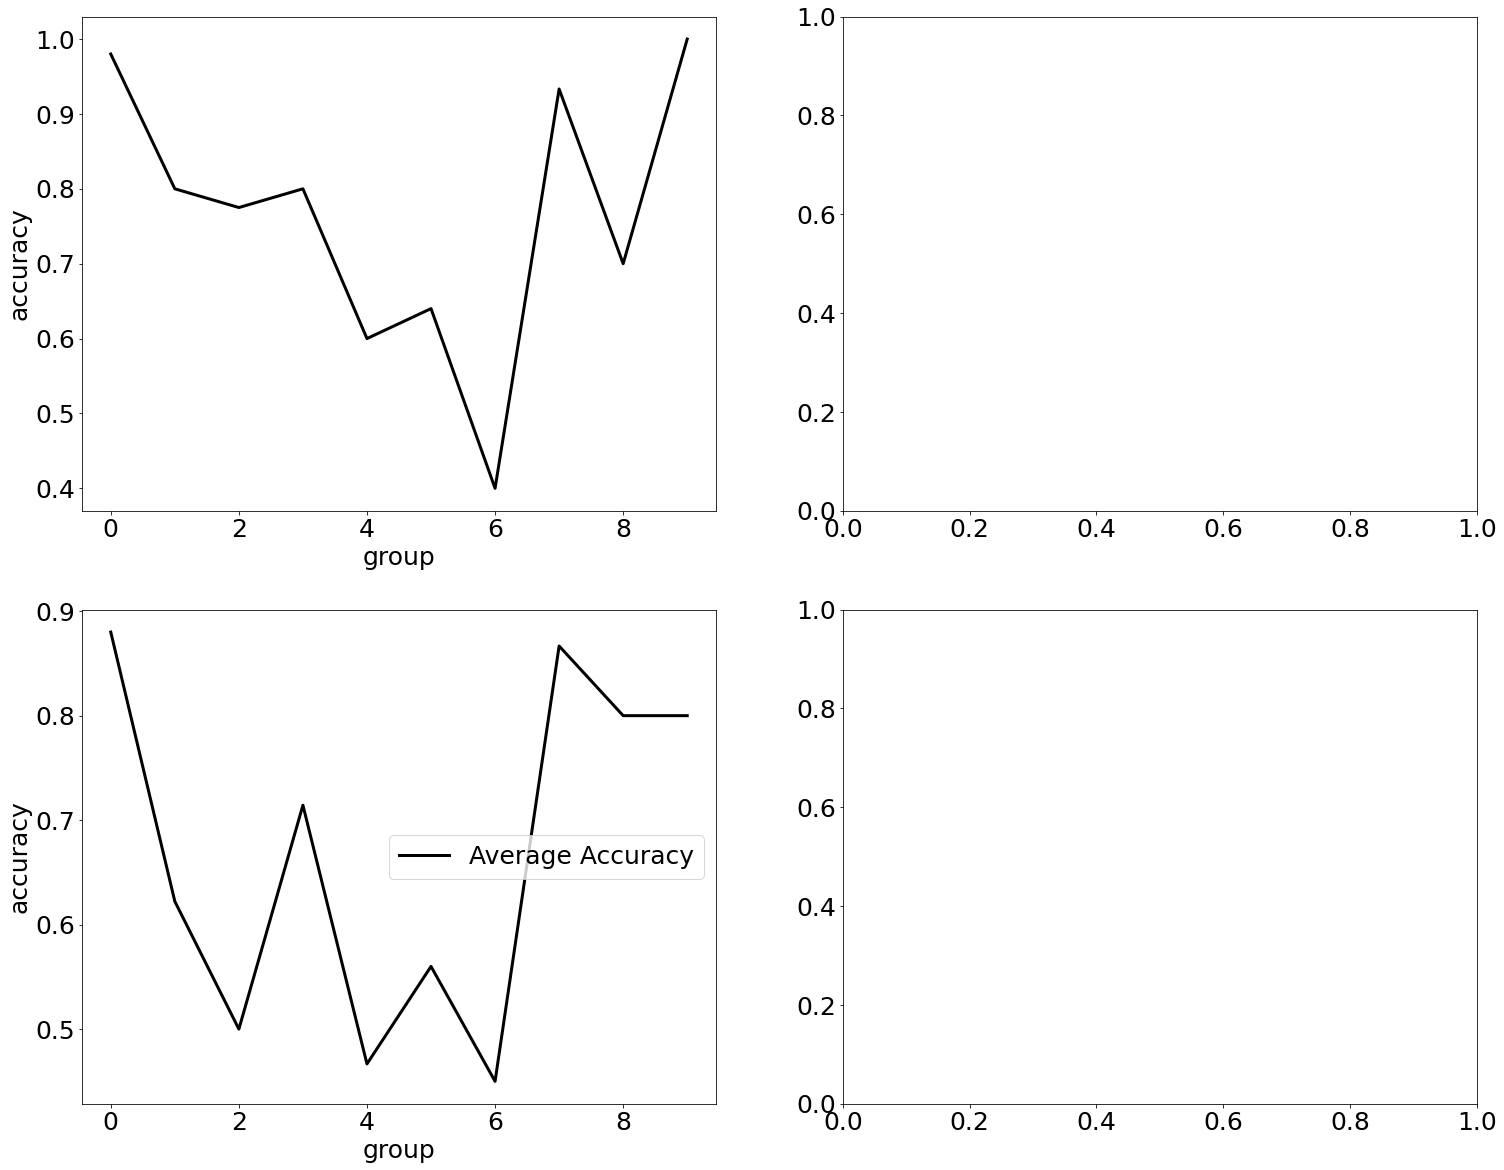

In [252]:


# make four subplots, one for MAMLCon and one for MAML
plt.figure(figsize=(25,20))

# set seaborn colour sceheme
sns.set_palette('colorblind')

# sns.set_palette()

ax1 = plt.subplot(221)
ax3 = plt.subplot(222)
ax2 = plt.subplot(223)
ax4 = plt.subplot(224)

plot_1_data = all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==True)&(all_data['N']==5)]
g1=sns.barplot(x='group', y='accuracy', hue='training_group', data=plot_1_data, ax=ax1)
# put line plot on top of ax1 bar plot of average accuracy of each group
sns.lineplot(x='group', y='accuracy', data=plot_1_data.groupby('group').mean(), ax=ax1, color='black', linewidth=3)

plot_2_data = all_data[(all_data['MAMLCon']==False)&(all_data['quick_adapt']==True)&(all_data['N']==5)]
g2=sns.barplot(x='group', y='accuracy', hue='training_group', data=plot_2_data, ax=ax2)
sns.lineplot(x='group', y='accuracy', data=plot_2_data.groupby('group').mean(), ax=ax2, color='black', linewidth=3, label='Average Accuracy')

g1.legend_.remove()
g2.legend_.remove()

# set titles
ax1.set_title('MAMLCon')
ax2.set_title('Normal Model')

# remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


plot_3_data = all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==False)&(all_data['N']==5)]
g3=sns.barplot(x='group', y='accuracy', hue='training_group', data=plot_3_data, ax=ax3)
sns.lineplot(x='group', y='accuracy', data=plot_3_data.groupby('group').mean(), ax=ax3, color='black', linewidth=3)

plot_4_data = all_data[(all_data['MAMLCon']==False)&(all_data['quick_adapt']==True)&(all_data['N']==5)]
g4=sns.barplot(x='group', y='accuracy', hue='training_group', data=plot_4_data, ax=ax4)
sns.lineplot(x='group', y='accuracy', data=plot_4_data.groupby('group').mean(), ax=ax4, color='black', linewidth=3, label='Average Accuracy')

g3.legend_.remove()
g4.legend_.remove()

# set titles
ax3.set_title('MAMLCon - No quick update')
ax4.set_title('Normal Model - No quick update')

# set all x labels to be blank
ax1.set_xlabel('Class Group')
ax2.set_xlabel('Class Group')
ax3.set_xlabel('Class Group')
ax4.set_xlabel('Class Group')

# set all x labels to be blank
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Accuracy')
ax3.set_ylabel('Accuracy')
ax4.set_ylabel('Accuracy')


# remove top and right spines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)


# make plot font size bigger

# put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Total Groups Trained', prop={'size': 10})

plt.rcParams.update({'font.size': 25})

# sup title closer to plots
plt.suptitle("Group Accuracies After Training Other Groups", y=0.95)

plt.savefig('group_accuracies.png', transparent=True, pad_inches=.2, frameon=False)
plt.show()

In [256]:
plot_1_data = all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==True)&(all_data['N']==5)]

plot_2_data = all_data[(all_data['MAMLCon']==False)&(all_data['quick_adapt']==True)&(all_data['N']==5)]

plot_3_data = all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==False)&(all_data['N']==5)]

plot_4_data = all_data[(all_data['MAMLCon']==False)&(all_data['quick_adapt']==True)&(all_data['N']==5)]


,group,loss,accuracy,training_group,N,quick_adapt,MAMLCon
0,0,0.074003,0.980000,4.5,5.0,1.0,1.0
1,1,0.882558,0.800000,5.0,5.0,1.0,1.0
2,2,0.721947,0.775000,5.5,5.0,1.0,1.0
3,3,0.781602,0.800000,6.0,5.0,1.0,1.0
4,4,1.293076,0.600000,6.5,5.0,1.0,1.0
5,5,1.425968,0.640000,7.0,5.0,1.0,1.0
6,6,2.352371,0.400000,7.5,5.0,1.0,1.0
7,7,0.341033,0.933333,8.0,5.0,1.0,1.0
8,8,1.439000,0.700000,8.5,5.0,1.0,1.0
9,9,0.220269,1.000000,9.0,5.0,1.0,1.0


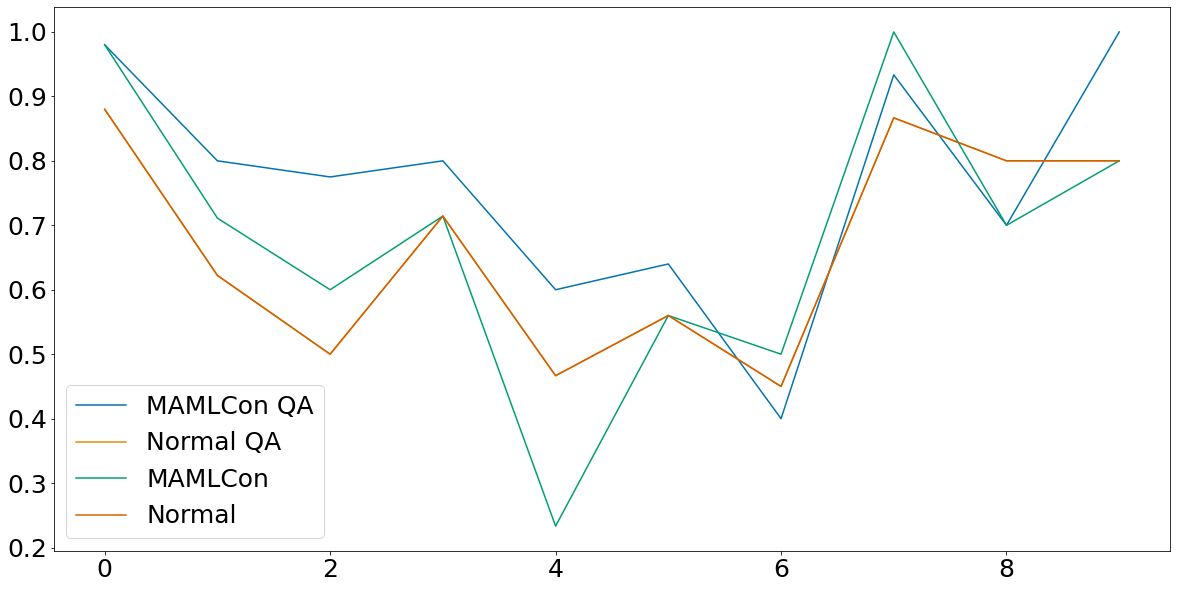

In [261]:
# sns.lineplot(x='group', y='accuracy', data=plot_1_data.groupby('group').mean(), ax=ax1, color='black', linewidth=3)
plt.figure(figsize=(20,10))
plt.plot(plot_1_data.groupby('group').mean().reset_index()['accuracy'], label='MAMLCon QA');
plt.plot(plot_2_data.groupby('group').mean().reset_index()['accuracy'], label='Normal QA');
plt.plot(plot_3_data.groupby('group').mean().reset_index()['accuracy'], label='MAMLCon');
plt.plot(plot_4_data.groupby('group').mean().reset_index()['accuracy'], label='Normal');
plt.legend()


In [180]:
all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==True)&(all_data['N']==5)]

,loss,accuracy,group,training_group,N,quick_adapt,MAMLCon
0,0.002085,1.0,0,0,5,True,True
1,0.008043,1.0,0,1,5,True,True
2,3.009262,0.8,1,1,5,True,True
3,0.052055,1.0,0,2,5,True,True
4,1.009119,0.8,1,2,5,True,True
...,...,...,...,...,...,...,...
10,0.317248,0.9,0,4,5,True,True
11,0.227230,1.0,1,4,5,True,True
12,0.563309,0.8,2,4,5,True,True
13,2.507740,0.4,3,4,5,True,True


In [181]:
all_data.N.unique()

array([5])